# Laboratorium 4: PyTorch Lightning — Baseline vs Transfer Learning (PathMNIST)

W tym ćwiczeniu chcemy wykozrystać **PyTorch Lightning**, który jest wysokopoziomowym frameworkiem nad PyTorchem, który porządkuje i automatyzuje kod trenowania sieci neuronowych.
Poprawia on czytelność kodu, ułatwia obsługę sprzętu oraz przyspiesza przeprowadzenie różnych eksperymentów.

**Cele:**
- zbudować prostą sieć CNN w **PyTorch Lightning** jako **baseline** (224×224),
- wykonać **Transfer Learning** z **ResNet18 (ImageNet)** jako model porównawczy (224×224),
- użyć **EarlyStopping** i **ModelCheckpoint**,
- porównać wyniki (Accuracy, Macro-F1) i obejrzeć **macierz pomyłek**.

**Dataset:** **PathMNIST (MedMNIST)** — automatycznie pobierany, 9 klas (RGB, 224x224×3). Jeśli chcemy zmniejszyć czas pobierania danych to można podać mniejszą rozdzielczość, ale dla transfer learningu z ResNet18 najlepiej podawać dane **przeskalowane do 224×224**. Zawiera on obrazki histopatologiczne do klasyfikacji zmian tkankowych.

> Najpierw trenujemy małą sieć CNN, zapisujemy najlepszy checkpoint, testujemy.
> Potem trenujemy model bazujący na ResNet18 z zamrożonym backbone i wykonujemy test najlepszej wersji oraz porównanie wyników. Potem opcjonalnie **odmrażamy** backbone (fine-tuning).

## 0) Instalacja i importy

In [1]:
# !pip -q install pytorch-lightning torchmetrics medmnist scikit-learn --extra-index-url https://download.pytorch.org/whl/cpu

import os, random, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, LightningDataModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix

import medmnist
from medmnist import PathMNIST, INFO
from torchvision.models import resnet18, ResNet18_Weights

SEED = 42
def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device, '| PyTorch Lightning:', pl.__version__)

Device: cuda | PyTorch Lightning: 2.5.5


## 1) Dane: PathMNIST (auto-download) i podgląd

Skrypt automatycznie pobiera zbiór **PathMNIST**. Poniższy kod sprawdza rozmiar danych i etykiety.
Wyświetlone zostaje również 6 pierwszych próbek z tego zbioru. W tym przypadku będziemy przetwarzać dane RGB o rozdzielczości 224x224, co znacznie wydłuża czas pobierania i przetwarzania danych. Dane tej rozdzielczości były wykorzystane w zbiorze **ImageNet**, przez co stała się ona domyślna dla wielu popularnych architektur wykorzystywanych przez transfer learning.

Opis: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.
Liczba klas: 9 | label map: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
Rozmiary: 89996 10004 7180


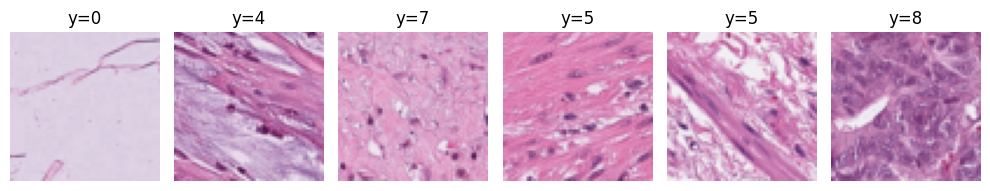

In [2]:
DATA_ROOT = './data/medmnist'
os.makedirs(DATA_ROOT, exist_ok=True)

info = INFO['pathmnist']
NUM_CLASSES = len(info['label'])
print('Opis:', info['description'])
print('Liczba klas:', NUM_CLASSES, '| label map:', info['label'])

train_raw = PathMNIST(split='train', download=True, root=DATA_ROOT, as_rgb=True, size=64)
val_raw   = PathMNIST(split='val',   download=True, root=DATA_ROOT, as_rgb=True, size=64)
test_raw  = PathMNIST(split='test',  download=True, root=DATA_ROOT, as_rgb=True, size=64)
print('Rozmiary:', len(train_raw), len(val_raw), len(test_raw))

# Podgląd przykładowych obrazów
fig, axes = plt.subplots(1, 6, figsize=(10,2))
for i in range(6):
    img, y = train_raw[i]
    axes[i].imshow(np.array(img))
    axes[i].set_title(f'y={int(y.squeeze().item())}')
    axes[i].axis('off')
plt.tight_layout(); plt.show()

## Zadanie 1 – Transformacje i DataModule

Konieczne jest zaimplementowanie dwóch zestawów augmentacji. Pierwszy dla naszej sieci, a drugi dla użytej przez transfer learning. Różnić się one muszą normalizacją.
1. Dla naszej, prostej architektury wykorzystujemy standardową normalizację `transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])`. 
2. Dla sieciach preuczonych na ImageNet musimy wykorzystać `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`.
3. Oprócz tego możemy wykorzystać odbicie w poziomie z prawdopodobieństwem 50% i rotację o maksymalny kąt 10 stopni. Oprócz tego oczywiście musimy skonwertować dane do Tensora.
4. Następnie musimy zaimplementować klasę, która będzie zarządzać wczytywaniem danych. Powinna ona dziedziczyć po klasie `LightningDataModule`. Musimy dla niej zaimplementować kilka metod:
    - `__init__`, dla której przekazujemy i zapamiętujemy transformacje dla augmentacji, `batch_size` i `num_workers`.
    - `setup(self, stage=None)` powinna wczytać zbiory treningowy, walidacyjny i testowy. Pamiętaj o przekazaniu rozmiaru `size` i augmentacji danych.
    - `train_dataloader`, `val_dataloader`, `test_dataloader` powinny zwracać DataLoadery dla poszczególnych zbiorów.
5. Następnie stwórz obiekty tej klasy oraz wykonaj metodę `.setup()`. Pobierz próbkę danych: `x, y = next(iter(dm.train_dataloader()))` i  sprawdź jej rozmiar.

In [3]:
# Zadanie 1
DATA_ROOT = './data/medmnist'
os.makedirs(DATA_ROOT, exist_ok=True)

info = INFO['pathmnist']
NUM_CLASSES = len(info['label'])
print('Opis:', info['description'])
print('Liczba klas:', NUM_CLASSES, '| label map:', info['label'])

train_transform_simple = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

train_transform_imagenet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


class MedMNISTDataModule(LightningDataModule):
    def __init__(self, data_dir=DATA_ROOT, batch_size=64, num_workers=23,
                 train_transform=None, val_test_transform=None, size=64):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_transform = train_transform
        self.val_test_transform = val_test_transform
        self.size = size

    def setup(self, stage=None):
        self.train_dataset = PathMNIST(split='train', download=True, root=self.data_dir,
                                       as_rgb=True, size=self.size, transform=self.train_transform)
        self.val_dataset = PathMNIST(split='val', download=True, root=self.data_dir,
                                     as_rgb=True, size=self.size, transform=self.val_test_transform)
        self.test_dataset = PathMNIST(split='test', download=True, root=self.data_dir,
                                      as_rgb=True, size=self.size, transform=self.val_test_transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)


dm = MedMNISTDataModule(train_transform=train_transform_simple,
                        val_test_transform=train_transform_simple,
                        batch_size=64, num_workers=2)

dm.setup()

x, y = next(iter(dm.train_dataloader()))
print("Rozmiar x:", x.shape)
print("Rozmiar y:", y.shape)

Opis: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.
Liczba klas: 9 | label map: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
Rozmiar x: torch.Size([64, 3, 224, 224])
Rozmiar y: torch.Size([64, 1])


## Zadanie 2 – Lightning **Baseline**: prosta CNN + metryki + optymalizator

Teraz stworzymy klasę prostej sieci z wykorzystaniem **PyTorch Lightning**. Klasa ta musi posiadać kilka metod: `__init__(self, ...)`, `forward(self, x)`, `configure_optimizers(self)`, `training_step(self, batch, batch_idx)`. Oprócz tego dobrze jest zaimplementować metody `validation_step(self, batch, batch_idx)`, `test_step(self, batch, batch_idx)`.
1. Do inicjalizacji przakaż liczbę klas oraz learning rate. Na początku zainicjalizuj klasę bazową `super().__init__()`, zapisz przekazane parametry `self.save_hyperparameters()` oraz zdefiniuj wykorzystywane warstwy. Chcemy użyć 5 warstw konwolucyjnych z ReLU i MaxPoolingiem, 3 warstwy w pełni połączone i dropout po dwóch pierwszych warstwach w pełni połączonych. Dodatkowo musimy zdefiniować obiekty do obliczania metryk. Chcemy obliczać dokładność dla zbiorów treningowego, walidacyjnego i testowego `MulticlassAccuracy` (przekazujemy jej liczbę klas `num_classes`), F1-score dla zbiorów walidacyjnego i testowego `MulticlassF1Score` (przekazujemy jej liczbę klas `num_classes` i metodę obliczania średniej - chcemy obliczyć `'macro'`) oraz macierz pomyłek dla zbioru testowego `MulticlassConfusionMatrix` (przekazujemy jej liczbę klas `num_classes`).
2. W metodzie `forward(self, x)` wykonujemy kolejne obliczenia sieci podobnie jak w poprzednich ćwiczeniach.
3. W metodzie `configure_optimizers(self)` musimy zdefiniować optymalizator. Wykorzystamy `torch.optim.Adam`. Oprócz tego chcemy zastosować LR scheduler. Jego zadaniem jest zmiana i dostosowywanie learning rate w trakcie uczenia. Wykorzystamy `torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=6)`, który zmienia learning rate zgodnie z funkcją kosinusoidalną. Metoda ta powinna zwracać słownik z odpowiednimi polami: `{'optimizer': opt, 'lr_scheduler': sch}`.
4. Pozostałe metody zawierają obliczenia, które wcześniej wykonywane były odpowiednio w pętlach treningowych, walidacyjnych i testowych. Oprócz tego musimy tam dodać obliczanie i logowanie metryk. Aby obliczyć metrykę musimy tylko przekazać jej obliczone predykcje i rzeczywiste etykiety. Logować chcemy zdefiniowane wcześniej metryki oraz stratę dla zbiorów treningowych i walidacyjnych. W tym celu wykorzystujemy funkcję `self.log`, której przyekazujemy argumenty:
    - nazwę logowanej wartości,
    - wartość,
    - `on_step` - czy logujemy po każdym kroku (ustawiamy na `False`),
    - `on_epoch` - czy logujemy po każdej epoce (ustawiamy na `True`),
    - `prog_bar` - czy wartość jest wyświetlana na pasku postępu (ustawiamy na `True`).

In [4]:
# Zadanie 2
class SimpleCNN(pl.LightningModule):
    def __init__(self, num_classes, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.flatten_dim = 512 * 7 * 7

        self.fc_layers = nn.Sequential(
            nn.Linear(self.flatten_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(256, num_classes)
        )

        self.train_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_acc = MulticlassAccuracy(num_classes=num_classes)
        self.test_acc = MulticlassAccuracy(num_classes=num_classes)

        self.val_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')
        self.test_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')

        self.test_cm = MulticlassConfusionMatrix(num_classes=num_classes)

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=6)
        return {"optimizer": opt, "lr_scheduler": sch}

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y.squeeze().long())
        preds = torch.argmax(y_hat, dim=1)

        acc = self.train_acc(preds, y.squeeze().long())

        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y.squeeze().long())
        preds = torch.argmax(y_hat, dim=1)

        acc = self.val_acc(preds, y.squeeze().long())
        f1 = self.val_f1(preds, y.squeeze().long())

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_f1", f1, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y.squeeze().long())
        preds = torch.argmax(y_hat, dim=1)

        acc = self.test_acc(preds, y.squeeze().long())
        f1 = self.test_f1(preds, y.squeeze().long())
        cm = self.test_cm(preds, y.squeeze().long())

        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_f1", f1, on_step=False, on_epoch=True, prog_bar=True)
        return {"test_loss": loss, "confmat": cm}


## Zadanie 3 – Trening **Baseline** z EarlyStopping + Checkpoint

Teraz chcemy przeprowadzić trening dla zaimplementowanej sieci.
1. Najpierw zdefiniuj obiekt klasy.
2. Chcemy dodatkowo wykorzystać early stopping. Pozwala on na wcześniejsze zatrzymanie treningu, jeśli od zadanej liczby epok nie poprawiła się zadana metryka dla zbioru walidacyjnego. W tym celu tworzymy obiekt `EarlyStopping`, któremu przekazujemy argumenty: `monitor` - nazwa obserwowanej metryki z logowania, `mode` - chcemy maksymalizować czy minimalizować, `patience` - po ilu epokach bez poprawy przerywamy trening.
3. Dodajemy również automatyczne zapisywanie najlepszego modelu za pomocą obiektu `ModelCheckpoint`. Przekazujemy argumenty: `monitor` - nazwa obserwowanej metryki z logowania, `mode` - chcemy maksymalizować czy minimalizować, `save_top_k` - ile najlepszych modeli zapisujemy, `filename` - nazwę zapisywanego pliku, np. `'baseline-small-{epoch:02d}-{val_f1:.3f}'`.
4. Aby przeprowadzić trening tworzymy obiekt `Trainer`, której przekazujemy argumenty: `max_eopch` - maksymalna liczba epok, `accelerator` - określa urządzenie do treningu (`'auto'` wybiera GPU jeśli dostępne, inaczej CPU), `devices` - ile urządzeń (GPU/CPU) używać, `callbacks` - lista callbacków używanych w treningu (u nas early stopping i checkpoint).
5. Następnie wywołujemy metodę `.fit`, której przekazujemy trenowaną klasę i obiekt klasy zarządzającej danymi jako argument `datamodule`.
6. Powinny zostać wyświetlona informacje o zaprojektowanej architekturze. Przeanalizuj je. Zwróć uwagę na liczbę parametrów sieci.

In [5]:
# Zadanie 3
model = SimpleCNN(num_classes=NUM_CLASSES, lr=1e-3)

early_stop = EarlyStopping(
    monitor='val_f1',
    mode='max',
    patience=5,
    verbose=True
)

checkpoint = ModelCheckpoint(
    monitor='val_f1',
    mode='max',
    save_top_k=1,
    filename='baseline-small-{epoch:02d}-{val_f1:.3f}',
    verbose=True
)

trainer = pl.Trainer(
    max_epochs=20,
    accelerator='auto',
    devices=1,
    callbacks=[early_stop, checkpoint],
    log_every_n_steps=10
)

trainer.fit(model, datamodule=dm)

print(model)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")
print(f"Best model path: {checkpoint.best_model_path}")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/karolina/studia/piaom/venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.htm

Epoch 0: 100%|██████████| 1407/1407 [02:33<00:00,  9.17it/s, v_num=8, val_loss=0.450, val_acc=0.850, val_f1=0.836, train_loss=0.824, train_acc=0.685]

Metric val_f1 improved. New best score: 0.836
Epoch 0, global step 1407: 'val_f1' reached 0.83643 (best 0.83643), saving model to '/home/karolina/studia/piaom/lab4/lightning_logs/version_8/checkpoints/baseline-small-epoch=00-val_f1=0.836.ckpt' as top 1


Epoch 1: 100%|██████████| 1407/1407 [02:33<00:00,  9.19it/s, v_num=8, val_loss=0.214, val_acc=0.928, val_f1=0.922, train_loss=0.351, train_acc=0.883]

Metric val_f1 improved by 0.086 >= min_delta = 0.0. New best score: 0.922
Epoch 1, global step 2814: 'val_f1' reached 0.92226 (best 0.92226), saving model to '/home/karolina/studia/piaom/lab4/lightning_logs/version_8/checkpoints/baseline-small-epoch=01-val_f1=0.922.ckpt' as top 1


Epoch 2: 100%|██████████| 1407/1407 [02:33<00:00,  9.18it/s, v_num=8, val_loss=0.175, val_acc=0.941, val_f1=0.936, train_loss=0.228, train_acc=0.925]

Metric val_f1 improved by 0.014 >= min_delta = 0.0. New best score: 0.936
Epoch 2, global step 4221: 'val_f1' reached 0.93608 (best 0.93608), saving model to '/home/karolina/studia/piaom/lab4/lightning_logs/version_8/checkpoints/baseline-small-epoch=02-val_f1=0.936.ckpt' as top 1


Epoch 3: 100%|██████████| 1407/1407 [02:33<00:00,  9.16it/s, v_num=8, val_loss=0.112, val_acc=0.964, val_f1=0.959, train_loss=0.155, train_acc=0.950]

Metric val_f1 improved by 0.023 >= min_delta = 0.0. New best score: 0.959
Epoch 3, global step 5628: 'val_f1' reached 0.95935 (best 0.95935), saving model to '/home/karolina/studia/piaom/lab4/lightning_logs/version_8/checkpoints/baseline-small-epoch=03-val_f1=0.959.ckpt' as top 1


Epoch 4: 100%|██████████| 1407/1407 [02:33<00:00,  9.16it/s, v_num=8, val_loss=0.119, val_acc=0.959, val_f1=0.955, train_loss=0.104, train_acc=0.965]

Epoch 4, global step 7035: 'val_f1' was not in top 1


Epoch 5: 100%|██████████| 1407/1407 [02:33<00:00,  9.17it/s, v_num=8, val_loss=0.072, val_acc=0.976, val_f1=0.975, train_loss=0.0729, train_acc=0.976]

Metric val_f1 improved by 0.015 >= min_delta = 0.0. New best score: 0.975
Epoch 5, global step 8442: 'val_f1' reached 0.97463 (best 0.97463), saving model to '/home/karolina/studia/piaom/lab4/lightning_logs/version_8/checkpoints/baseline-small-epoch=05-val_f1=0.975.ckpt' as top 1


Epoch 6: 100%|██████████| 1407/1407 [02:33<00:00,  9.16it/s, v_num=8, val_loss=0.0695, val_acc=0.977, val_f1=0.975, train_loss=0.0671, train_acc=0.978]

Metric val_f1 improved by 0.000 >= min_delta = 0.0. New best score: 0.975
Epoch 6, global step 9849: 'val_f1' reached 0.97505 (best 0.97505), saving model to '/home/karolina/studia/piaom/lab4/lightning_logs/version_8/checkpoints/baseline-small-epoch=06-val_f1=0.975.ckpt' as top 1


Epoch 7: 100%|██████████| 1407/1407 [02:33<00:00,  9.16it/s, v_num=8, val_loss=0.067, val_acc=0.979, val_f1=0.977, train_loss=0.0676, train_acc=0.978] 

Metric val_f1 improved by 0.002 >= min_delta = 0.0. New best score: 0.977
Epoch 7, global step 11256: 'val_f1' reached 0.97691 (best 0.97691), saving model to '/home/karolina/studia/piaom/lab4/lightning_logs/version_8/checkpoints/baseline-small-epoch=07-val_f1=0.977.ckpt' as top 1


Epoch 8: 100%|██████████| 1407/1407 [02:33<00:00,  9.17it/s, v_num=8, val_loss=0.0754, val_acc=0.974, val_f1=0.972, train_loss=0.0875, train_acc=0.970]

Epoch 8, global step 12663: 'val_f1' was not in top 1


Epoch 9: 100%|██████████| 1407/1407 [02:33<00:00,  9.15it/s, v_num=8, val_loss=0.0946, val_acc=0.967, val_f1=0.965, train_loss=0.114, train_acc=0.962] 

Epoch 9, global step 14070: 'val_f1' was not in top 1


Epoch 10: 100%|██████████| 1407/1407 [02:33<00:00,  9.15it/s, v_num=8, val_loss=0.147, val_acc=0.954, val_f1=0.950, train_loss=0.133, train_acc=0.957] 

Epoch 10, global step 15477: 'val_f1' was not in top 1


Epoch 11: 100%|██████████| 1407/1407 [02:33<00:00,  9.15it/s, v_num=8, val_loss=0.119, val_acc=0.963, val_f1=0.959, train_loss=0.139, train_acc=0.955]

Epoch 11, global step 16884: 'val_f1' was not in top 1


Epoch 12: 100%|██████████| 1407/1407 [02:33<00:00,  9.16it/s, v_num=8, val_loss=0.133, val_acc=0.956, val_f1=0.954, train_loss=0.146, train_acc=0.955]

Monitored metric val_f1 did not improve in the last 5 records. Best score: 0.977. Signaling Trainer to stop.
Epoch 12, global step 18291: 'val_f1' was not in top 1


Epoch 12: 100%|██████████| 1407/1407 [02:33<00:00,  9.16it/s, v_num=8, val_loss=0.133, val_acc=0.956, val_f1=0.954, train_loss=0.146, train_acc=0.955]
SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): 

## Zadanie 4 – Test baseline + macierz pomyłek

Teraz chcemy przeprowadzić test wytrenowanej sieci.
1. Najpierw musimy wczytać model dla którego osiągnięto najlepszy wynik (checkpoint). Wykorzystujemy w tym celu metodę `.load_from_checkpoint` dla klasy implementującej naszą sieć. Jako argument przekazujemy ścieżkę do checkpointu `ckpt.best_model_path`.
2. Aby przeprowadzić test należy wywołać matodę `.test` trainera. Pierwszym argumentem jest obiekt z wczytanego checkpointu, a drugim jest obiekt zarządzający danymi jako `datamodule`.
3. Confusion matrix jest obliczane przez wywołanie i przypisanie wyjścia dla `best_baseline.test_cm.compute().cpu().numpy()`. Następnie wyświetlamy macierz pomyłek. Wcześniejsze wywołanie metody `.test` powinno spowodować wyświetlenie logowanych metryk dla zbioru testowego.

Loaded best model from file:
/home/karolina/studia/piaom/lab4/lightning_logs/version_8/checkpoints/baseline-small-epoch=07-val_f1=0.977.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 113/113 [00:05<00:00, 22.36it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8508827686309814
         test_f1            0.8329662084579468
        test_loss           0.6160275936126709
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


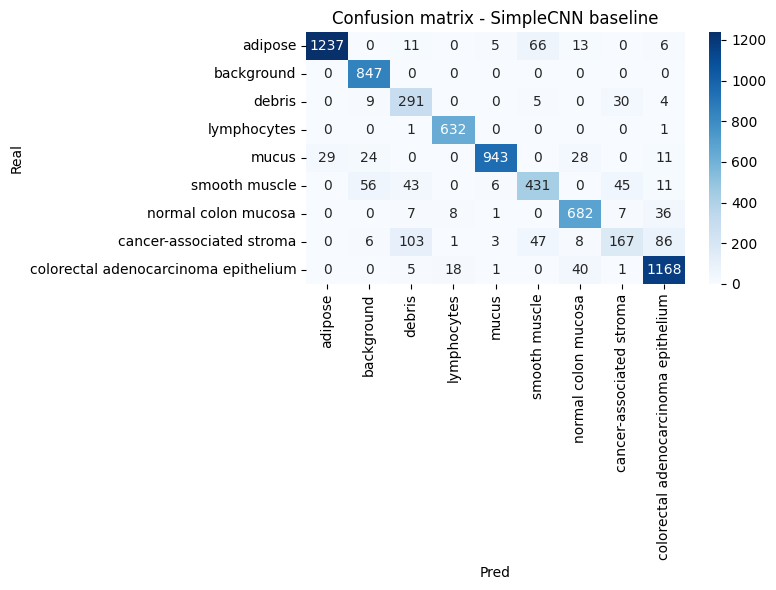

In [6]:
# Zadanie 4
import seaborn as sns

best_baseline = SimpleCNN.load_from_checkpoint(checkpoint.best_model_path)

print(f"Loaded best model from file:\n{checkpoint.best_model_path}")

trainer.test(best_baseline, datamodule=dm)

cm = best_baseline.test_cm.compute().cpu().numpy()

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(info['label'].values()),
            yticklabels=list(info['label'].values()))
plt.title('Confusion matrix - SimpleCNN baseline')
plt.xlabel('Pred')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

## Zadanie 5 – Lightning **Transfer Learning**: ResNet18 (pretrained, head-only) + metryki

Teraz chcemy wykorzystać backbone sieci, która została już wcześniej wytrenowana. Backbone to główna część sieci, odpowiedzialna za ekstrakcję cech (feature extraction). Zwykle jest to duża, sprawdzona architektura, używana jako uniwersalny ekstraktor reprezentacji. Head to końcowa część sieci, która dostosowuje wyekstrahowane cechy do konkretnego zadania. Jako backbone chcemy wykorzystać ResNet18, a jako head prostą, w pełni połączoną, warstwę liniową.

1. Kod całej klasy jest bardzo podobny do zaimplementowanej wcześniej. Do argumentów inicjalizacji dodajemy flagę oznaczającą zamrożenie backbone (jego parametry nie będę zmieniane w trakcie treningu).
2. Wagi wczytujemy za pomocą `weights = ResNet18_Weights.IMAGENET1K_V1`. Następnie musimy je przekazań do funkcji `resnet18` jako argument `weights`. 
3. W ResNecie na końcu jest warstwa w pełni połączona (jako head). Liczbę jej wejść możemy sprawdzić za pomocą `self.backbone.fc.in_features`.Na podstawie tej wielkości i liczby klas modyfikujemy tą ostatnią warstwę: `self.backbone.fc = nn.Linear(in_features, num_classes)`.
4. Stwórz metryki skuteczności.
5. Sprawdź flagę zamrożenia backbone. Jeśli jest ustawione, to wykonaj kod (lub włóż do funkcji):
```Python
    for name, p in self.backbone.named_parameters():
        if not name.startswith('fc'):
            p.requires_grad = False
```
6. Zaimplementuj metodę `forward`.
7. Zaimplementuj metodę `configure_optimizers`. W tym wypadku przekazując parametry do optymalizatora musimy usunąć te, dla których wyłączyliśmy obliczanie gradientu: `params = filter(lambda p: p.requires_grad, self.parameters())`.
8. Pozostałe metody są takie same jak we wcześniejszej klasie.

In [7]:
# Zadanie 5
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassF1Score,
    MulticlassConfusionMatrix
)

class ResNet18Transfer(pl.LightningModule):
    def __init__(self, num_classes, lr=1e-4, freeze_backbone=False):
        super().__init__()
        self.save_hyperparameters()
        weights = ResNet18_Weights.IMAGENET1K_V1
        self.backbone = resnet18(weights=weights)

        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_features, num_classes)

        self.train_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_acc = MulticlassAccuracy(num_classes=num_classes)
        self.test_acc = MulticlassAccuracy(num_classes=num_classes)

        self.val_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')
        self.test_f1 = MulticlassF1Score(num_classes=num_classes, average='macro')

        self.test_cm = MulticlassConfusionMatrix(num_classes=num_classes)

        if freeze_backbone:
            for name, p in self.backbone.named_parameters():
                if not name.startswith('fc'):
                    p.requires_grad = False

    def forward(self, x):
        return self.backbone(x)

    def configure_optimizers(self):
        params = filter(lambda p: p.requires_grad, self.parameters())
        opt = torch.optim.Adam(params, lr=self.hparams.lr)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=6)
        return {"optimizer": opt, "lr_scheduler": sch}

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y.squeeze().long())
        preds = torch.argmax(y_hat, dim=1)

        acc = self.train_acc(preds, y.squeeze().long())
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y.squeeze().long())
        preds = torch.argmax(y_hat, dim=1)

        acc = self.val_acc(preds, y.squeeze().long())
        f1 = self.val_f1(preds, y.squeeze().long())

        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_f1", f1, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y.squeeze().long())
        preds = torch.argmax(y_hat, dim=1)

        acc = self.test_acc(preds, y.squeeze().long())
        f1 = self.test_f1(preds, y.squeeze().long())
        cm = self.test_cm(preds, y.squeeze().long())

        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
        self.log("test_f1", f1, on_step=False, on_epoch=True, prog_bar=True)
        return {"test_loss": loss, "confmat": cm}

## Zadanie 6 – Trening Transfer Learning (head-only) z EarlyStopping + Checkpoint

Przeprowadź trening dla zaimplementowanej sieci z TL i zamrożonym backbone.

In [8]:
# Zadanie 6
DATA_ROOT = './data/medmnist'
os.makedirs(DATA_ROOT, exist_ok=True)

info = INFO['pathmnist']
NUM_CLASSES = len(info['label'])
print('Description:', info['description'])
print('Number of classes:', NUM_CLASSES, '| label map:', info['label'])

train_transform_imagenet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform_imagenet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dm = MedMNISTDataModule(
    data_dir=DATA_ROOT,
    batch_size=64,
    num_workers=2,
    train_transform=train_transform_imagenet,
    val_test_transform=val_test_transform_imagenet,
    size=64
)
dm.setup()

model_resnet_tl = ResNet18Transfer(
    num_classes=NUM_CLASSES,
    lr=1e-4,
    freeze_backbone=True
)

early_stop = EarlyStopping(
    monitor='val_f1',
    mode='max',
    patience=5,
    verbose=True
)

checkpoint_resnet = ModelCheckpoint(
    monitor='val_f1',
    mode='max',
    save_top_k=1,
    filename='resnet18-tl-{epoch:02d}-{val_f1:.3f}'
)

trainer = pl.Trainer(
    max_epochs=15,
    accelerator='auto',
    devices=1,
    callbacks=[early_stop, checkpoint_resnet],
    log_every_n_steps=10
)

trainer.fit(model_resnet_tl, datamodule=dm)

print(f"Best model saved in: {checkpoint_resnet.best_model_path}")

Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.
Number of classes: 9 | label map: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params | Mode 
----------------------------------------------------------------
0 | backbone  | ResNet                    | 11.2 M | train
1 | train_acc | MulticlassAccuracy        | 0      | train
2 | val_acc   | MulticlassAccuracy        | 0      | train
3 | test_acc  | MulticlassAccuracy        | 0      | train
4 | val_f1    | MulticlassF1Score         | 0      | train
5 | test_f1   | MulticlassF1Score         | 0      | train
6 | test_cm   | MulticlassConfusionMatrix | 0      | train
----------------------------------------------------------------
4.6 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.725    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1407/1407 [01:14<00:00, 18.84it/s, v_num=9, val_loss=0.515, val_acc=0.854, val_f1=0.842, train_loss=0.914, train_acc=0.763]

Metric val_f1 improved. New best score: 0.842


Epoch 1: 100%|██████████| 1407/1407 [01:15<00:00, 18.75it/s, v_num=9, val_loss=0.382, val_acc=0.877, val_f1=0.868, train_loss=0.461, train_acc=0.873]

Metric val_f1 improved by 0.026 >= min_delta = 0.0. New best score: 0.868


Epoch 2: 100%|██████████| 1407/1407 [01:15<00:00, 18.68it/s, v_num=9, val_loss=0.355, val_acc=0.882, val_f1=0.872, train_loss=0.387, train_acc=0.887]

Metric val_f1 improved by 0.004 >= min_delta = 0.0. New best score: 0.872


Epoch 3: 100%|██████████| 1407/1407 [01:15<00:00, 18.66it/s, v_num=9, val_loss=0.331, val_acc=0.890, val_f1=0.881, train_loss=0.356, train_acc=0.894]

Metric val_f1 improved by 0.008 >= min_delta = 0.0. New best score: 0.881


Epoch 4: 100%|██████████| 1407/1407 [01:15<00:00, 18.63it/s, v_num=9, val_loss=0.320, val_acc=0.894, val_f1=0.885, train_loss=0.344, train_acc=0.897]

Metric val_f1 improved by 0.004 >= min_delta = 0.0. New best score: 0.885


Epoch 7: 100%|██████████| 1407/1407 [01:15<00:00, 18.64it/s, v_num=9, val_loss=0.311, val_acc=0.898, val_f1=0.889, train_loss=0.337, train_acc=0.898]

Metric val_f1 improved by 0.005 >= min_delta = 0.0. New best score: 0.889


Epoch 9: 100%|██████████| 1407/1407 [01:15<00:00, 18.56it/s, v_num=9, val_loss=0.294, val_acc=0.902, val_f1=0.895, train_loss=0.325, train_acc=0.901]

Metric val_f1 improved by 0.005 >= min_delta = 0.0. New best score: 0.895


Epoch 10: 100%|██████████| 1407/1407 [01:15<00:00, 18.62it/s, v_num=9, val_loss=0.287, val_acc=0.905, val_f1=0.897, train_loss=0.314, train_acc=0.904]

Metric val_f1 improved by 0.002 >= min_delta = 0.0. New best score: 0.897


Epoch 11: 100%|██████████| 1407/1407 [01:15<00:00, 18.59it/s, v_num=9, val_loss=0.277, val_acc=0.908, val_f1=0.900, train_loss=0.303, train_acc=0.906]

Metric val_f1 improved by 0.003 >= min_delta = 0.0. New best score: 0.900


Epoch 12: 100%|██████████| 1407/1407 [01:15<00:00, 18.54it/s, v_num=9, val_loss=0.268, val_acc=0.909, val_f1=0.902, train_loss=0.291, train_acc=0.910]

Metric val_f1 improved by 0.002 >= min_delta = 0.0. New best score: 0.902


Epoch 13: 100%|██████████| 1407/1407 [01:16<00:00, 18.48it/s, v_num=9, val_loss=0.265, val_acc=0.910, val_f1=0.902, train_loss=0.286, train_acc=0.910]

Metric val_f1 improved by 0.000 >= min_delta = 0.0. New best score: 0.902


Epoch 14: 100%|██████████| 1407/1407 [01:15<00:00, 18.62it/s, v_num=9, val_loss=0.257, val_acc=0.912, val_f1=0.905, train_loss=0.279, train_acc=0.911]

Metric val_f1 improved by 0.002 >= min_delta = 0.0. New best score: 0.905
`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 1407/1407 [01:15<00:00, 18.60it/s, v_num=9, val_loss=0.257, val_acc=0.912, val_f1=0.905, train_loss=0.279, train_acc=0.911]
Best model saved in: /home/karolina/studia/piaom/lab4/lightning_logs/version_9/checkpoints/resnet18-tl-epoch=14-val_f1=0.905.ckpt


## Zadanie 7 – Test transfer + macierz pomyłek + porównanie metryk (Baseline vs Transfer)

Sprawdź metryki dla zbioru testowego i wyświetl macierz pomyłek.

Loaded baseline model: /home/karolina/studia/piaom/lab4/lightning_logs/version_8/checkpoints/baseline-small-epoch=07-val_f1=0.977.ckpt
Loaded transfer learning model: /home/karolina/studia/piaom/lab4/lightning_logs/version_8/checkpoints/baseline-small-epoch=07-val_f1=0.977.ckpt

Test baseline model:


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 113/113 [00:05<00:00, 22.50it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.15369606018066406
         test_f1            0.03886250779032707
        test_loss            79.16062927246094
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Test transfer learning model:


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 113/113 [00:05<00:00, 22.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8764538764953613
         test_f1             0.861286461353302
        test_loss            0.274081826210022
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


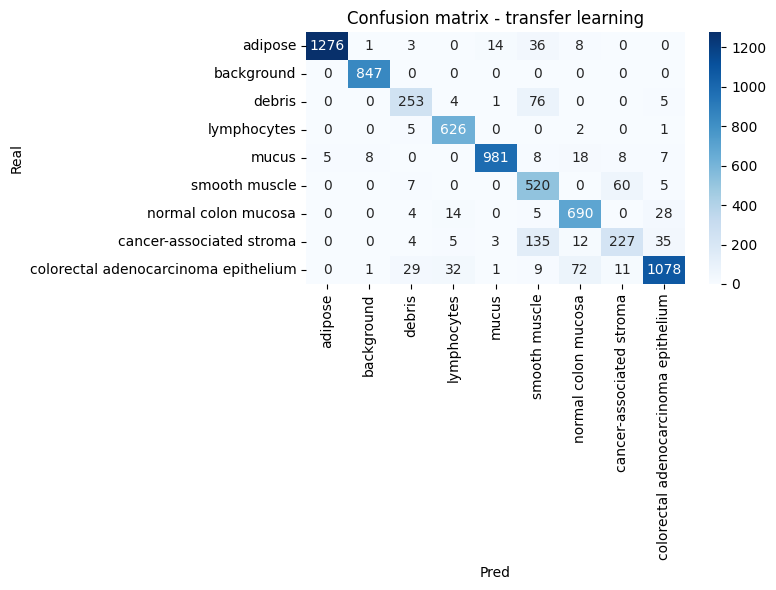

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 113/113 [00:05<00:00, 21.91it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 113/113 [00:05<00:00, 20.95it/s]

Comparison:
Metric                   Baseline     Transfer
---------------------------------------------
test_loss                 79.1606       0.2741
test_acc                   0.1537       0.8765
test_f1                    0.0389       0.8613


In [9]:
# Zadanie 7

checkpoint_baseline = checkpoint

best_baseline = SimpleCNN.load_from_checkpoint(checkpoint_baseline.best_model_path)
print(f"Loaded baseline model: {checkpoint_baseline.best_model_path}")

best_transfer = ResNet18Transfer.load_from_checkpoint(checkpoint_resnet.best_model_path)
print(f"Loaded transfer learning model: {checkpoint.best_model_path}")

print("\nTest baseline model:")
trainer.test(best_baseline, datamodule=dm)

print("\nTest transfer learning model:")
trainer.test(best_transfer, datamodule=dm)

cm_transfer = best_transfer.test_cm.compute().cpu().numpy()

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_transfer,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=list(info['label'].values()),
    yticklabels=list(info['label'].values())
)
plt.title('Confusion matrix - transfer learning')
plt.xlabel('Pred')
plt.ylabel('Real')
plt.tight_layout()
plt.show()

results_baseline = trainer.test(best_baseline, datamodule=dm, verbose=False)[0]
results_transfer = trainer.test(best_transfer, datamodule=dm, verbose=False)[0]

print("\nComparison:")
print(f"{'Metric':<20} {'Baseline':>12} {'Transfer':>12}")
print("-" * 45)
for metric in results_baseline.keys():
    b_val = results_baseline[metric]
    t_val = results_transfer[metric]
    print(f"{metric:<20} {b_val:>12.4f} {t_val:>12.4f}")

## Zadanie 8 – Fine tuning

W tym przypadku chcemy odmrozić wagi backbone i douczyć całą sieć.
1. Do zaimplementowanej wcześniej funkcji dodajemy funkcję, która pozwala na odmrożenie wag backbone:
```Python
    for p in self.backbone.parameters():
        p.requires_grad = True
```
2. Załaduj najlepszy checkpoint trenowanej sieci.
3. Odmroź backbone.
4. Zmniejsz learning rate: `fine_tune_model.hparams.lr = 1e-4`.
5. Dodaj early stopping i zapisywanie najlepszego checkpointu.
6. Przygotuj trainer i uruchom trening sieci.

In [10]:
# Zadanie 8
fine_tune_model = ResNet18Transfer.load_from_checkpoint(checkpoint_resnet.best_model_path)
print(f"Loaded model from checkpoint: {checkpoint.best_model_path}")

for p in fine_tune_model.backbone.parameters():
    p.requires_grad = True
print("Backbone unfreezed.")

fine_tune_model.hparams.lr = 1e-4
print(f"Learning rate: {fine_tune_model.hparams.lr}")

early_stop_ft = EarlyStopping(
    monitor='val_f1',
    mode='max',
    patience=5,
    verbose=True
)

checkpoint_ft = ModelCheckpoint(
    monitor='val_f1',
    mode='max',
    save_top_k=1,
    filename='resnet18-finetune-{epoch:02d}-{val_f1:.3f}'
)

trainer_ft = pl.Trainer(
    max_epochs=10,
    accelerator='auto',
    devices=1,
    callbacks=[early_stop_ft, checkpoint_ft],
    log_every_n_steps=10
)

print("Fine-tuning ResNet...")
trainer_ft.fit(fine_tune_model, datamodule=dm)

print(f"Best model saved in: {checkpoint_ft.best_model_path}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loaded model from checkpoint: /home/karolina/studia/piaom/lab4/lightning_logs/version_8/checkpoints/baseline-small-epoch=07-val_f1=0.977.ckpt
Backbone unfreezed.
Learning rate: 0.0001
Fine-tuning ResNet...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params | Mode 
----------------------------------------------------------------
0 | backbone  | ResNet                    | 11.2 M | train
1 | train_acc | MulticlassAccuracy        | 0      | train
2 | val_acc   | MulticlassAccuracy        | 0      | train
3 | test_acc  | MulticlassAccuracy        | 0      | train
4 | val_f1    | MulticlassF1Score         | 0      | train
5 | test_f1   | MulticlassF1Score         | 0      | train
6 | test_cm   | MulticlassConfusionMatrix | 0      | train
----------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.725    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 1407/1407 [03:03<00:00,  7.67it/s, v_num=10, val_loss=0.0388, val_acc=0.988, val_f1=0.987, train_loss=0.102, train_acc=0.969]

Metric val_f1 improved. New best score: 0.987


Epoch 1: 100%|██████████| 1407/1407 [03:03<00:00,  7.67it/s, v_num=10, val_loss=0.0259, val_acc=0.993, val_f1=0.992, train_loss=0.0422, train_acc=0.987]

Metric val_f1 improved by 0.006 >= min_delta = 0.0. New best score: 0.992


Epoch 2: 100%|██████████| 1407/1407 [03:03<00:00,  7.67it/s, v_num=10, val_loss=0.0224, val_acc=0.994, val_f1=0.993, train_loss=0.0254, train_acc=0.992]

Metric val_f1 improved by 0.000 >= min_delta = 0.0. New best score: 0.993


Epoch 3: 100%|██████████| 1407/1407 [03:03<00:00,  7.66it/s, v_num=10, val_loss=0.0156, val_acc=0.995, val_f1=0.995, train_loss=0.0158, train_acc=0.995]

Metric val_f1 improved by 0.002 >= min_delta = 0.0. New best score: 0.995


Epoch 4: 100%|██████████| 1407/1407 [03:03<00:00,  7.66it/s, v_num=10, val_loss=0.00846, val_acc=0.998, val_f1=0.997, train_loss=0.00739, train_acc=0.998]

Metric val_f1 improved by 0.003 >= min_delta = 0.0. New best score: 0.997


Epoch 5: 100%|██████████| 1407/1407 [03:03<00:00,  7.65it/s, v_num=10, val_loss=0.0063, val_acc=0.998, val_f1=0.998, train_loss=0.00421, train_acc=0.999] 

Metric val_f1 improved by 0.000 >= min_delta = 0.0. New best score: 0.998


Epoch 7: 100%|██████████| 1407/1407 [03:04<00:00,  7.64it/s, v_num=10, val_loss=0.00613, val_acc=0.998, val_f1=0.998, train_loss=0.00329, train_acc=0.999]

Metric val_f1 improved by 0.000 >= min_delta = 0.0. New best score: 0.998


Epoch 9: 100%|██████████| 1407/1407 [03:04<00:00,  7.64it/s, v_num=10, val_loss=0.0136, val_acc=0.997, val_f1=0.996, train_loss=0.0143, train_acc=0.996]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1407/1407 [03:04<00:00,  7.63it/s, v_num=10, val_loss=0.0136, val_acc=0.997, val_f1=0.996, train_loss=0.0143, train_acc=0.996]
Best model saved in: /home/karolina/studia/piaom/lab4/lightning_logs/version_10/checkpoints/resnet18-finetune-epoch=07-val_f1=0.998.ckpt


## Zadanie 9 – Test najlepszego checkpointu i podsumowanie wszystkich wyników

✅ Wczytano modele:
Baseline:     /home/karolina/studia/piaom/lab4/lightning_logs/version_8/checkpoints/baseline-small-epoch=07-val_f1=0.977.ckpt
Transfer TL:  /home/karolina/studia/piaom/lab4/lightning_logs/version_9/checkpoints/resnet18-tl-epoch=14-val_f1=0.905.ckpt
Fine-tuning:  /home/karolina/studia/piaom/lab4/lightning_logs/version_10/checkpoints/resnet18-finetune-epoch=07-val_f1=0.998.ckpt

🔹 Test – Baseline:


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 113/113 [00:05<00:00, 22.44it/s]

🔹 Test – Transfer Learning (ResNet18):


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 113/113 [00:05<00:00, 21.85it/s]

🔹 Test – Fine-tuned ResNet18:


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 113/113 [00:05<00:00, 21.93it/s]


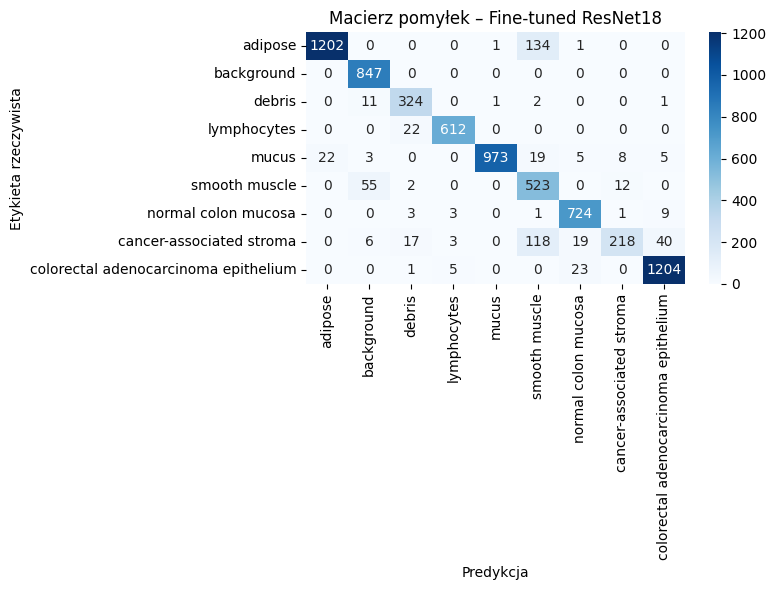


📊 Podsumowanie wyników:
                       Model  Test Loss  Test Acc  Test F1
        Baseline (SimpleCNN)  79.160629  0.153696 0.038863
Transfer Learning (ResNet18)   0.274082  0.876454 0.861286
         Fine-tuned ResNet18   0.425548  0.903569 0.891927


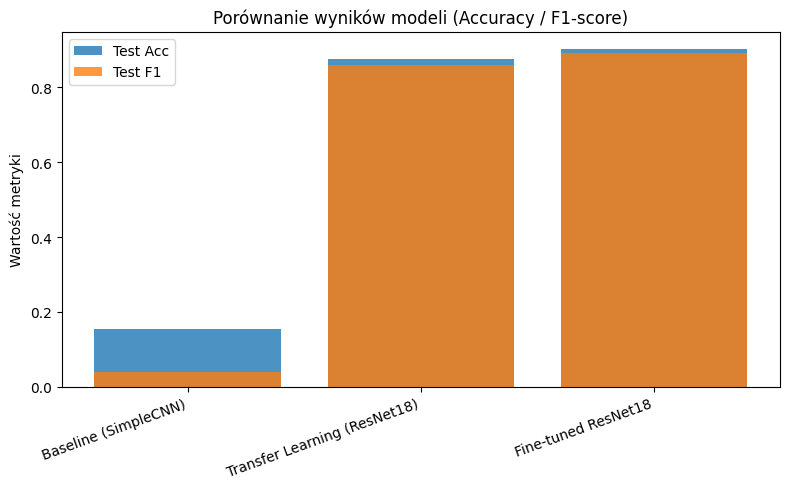

In [12]:
# Zadanie 9
import pandas as pd

best_baseline = SimpleCNN.load_from_checkpoint(checkpoint_baseline.best_model_path)
best_transfer = ResNet18Transfer.load_from_checkpoint(checkpoint_resnet.best_model_path)
best_finetuned = ResNet18Transfer.load_from_checkpoint(checkpoint_ft.best_model_path)

print("✅ Wczytano modele:")
print(f"Baseline:     {checkpoint_baseline.best_model_path}")
print(f"Transfer TL:  {checkpoint_resnet.best_model_path}")
print(f"Fine-tuning:  {checkpoint_ft.best_model_path}")

# --- 2️⃣ Testowanie wszystkich modeli ---
print("\n🔹 Test – Baseline:")
results_baseline = trainer.test(best_baseline, datamodule=dm, verbose=False)[0]

print("\n🔹 Test – Transfer Learning (ResNet18):")
results_transfer = trainer.test(best_transfer, datamodule=dm, verbose=False)[0]

print("\n🔹 Test – Fine-tuned ResNet18:")
results_finetuned = trainer.test(best_finetuned, datamodule=dm, verbose=False)[0]

# --- 3️⃣ Macierz pomyłek dla najlepszego (fine-tuned) modelu ---
cm_ft = best_finetuned.test_cm.compute().cpu().numpy()

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_ft,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=list(info['label'].values()),
    yticklabels=list(info['label'].values())
)
plt.title('Macierz pomyłek – Fine-tuned ResNet18')
plt.xlabel('Predykcja')
plt.ylabel('Etykieta rzeczywista')
plt.tight_layout()
plt.show()

# --- 4️⃣ Podsumowanie wyników ---
summary = pd.DataFrame([
    {
        "Model": "Baseline (SimpleCNN)",
        "Test Loss": results_baseline["test_loss"],
        "Test Acc": results_baseline["test_acc"],
        "Test F1": results_baseline["test_f1"],
    },
    {
        "Model": "Transfer Learning (ResNet18)",
        "Test Loss": results_transfer["test_loss"],
        "Test Acc": results_transfer["test_acc"],
        "Test F1": results_transfer["test_f1"],
    },
    {
        "Model": "Fine-tuned ResNet18",
        "Test Loss": results_finetuned["test_loss"],
        "Test Acc": results_finetuned["test_acc"],
        "Test F1": results_finetuned["test_f1"],
    }
])

print("\n📊 Podsumowanie wyników:")
print(summary.to_string(index=False))

# --- 5️⃣ Wizualne porównanie metryk ---
plt.figure(figsize=(8, 5))
metrics = ["Test Acc", "Test F1"]
for metric in metrics:
    plt.bar(summary["Model"], summary[metric], label=metric, alpha=0.8)
plt.title("Porównanie wyników modeli (Accuracy / F1-score)")
plt.ylabel("Wartość metryki")
plt.xticks(rotation=20, ha='right')
plt.legend()
plt.tight_layout()
plt.show()